In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.integrate import quad
from scipy.optimize import brute
import calendar
from datetime import datetime, timedelta, date
import pytz
from yahoo_fin import stock_info as si
from yahoo_fin import news
import statsmodels.api as sm
import ssl
import requests
import json
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC, abstractmethod
from tqdm import tqdm
from Utils.APIs import DataSourcer, Notion
ssl._create_default_https_context = ssl._create_unverified_context
pio.renderers.default = "notebook"
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 1000)
sns.set()
%load_ext autoreload
%autoreload 2
# http://theautomatic.net/yahoo_fin-documentation/#get_quote_data
# https://www.bitstamp.net/api/#ticker
# https://medium.com/coinmonks/sourcing-intra-day-crypto-data-c804ea199baf
# https://www.cryptodatadownload.com/data/bitstamp/

In [2]:
def convert_UTC_to_Central(t, formating=""):
    from_zone = pytz.timezone("UTC")
    to_zone = pytz.timezone("America/Chicago")
    
    if type(t)==str:
        utc = datetime.strptime(t, formating)
    else:
        utc = t
    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc = utc.replace(tzinfo=from_zone)
    # Convert the time zone
    cst = utc.astimezone(to_zone)
    return cst

In [3]:
def compute_pnl(transactions, asset):
    sub = transactions[transactions["Asset"] == asset]
    ticker = asset+"-USD"
    prev_price, unit, pnl = 0, 0, 0
    for idx, row in sub.iterrows():
        price = row["Spot Price at Transaction"]
        pnl += unit * (price-prev_price)
        if row["Transaction Type"] == "Buy": 
            unit += row["Quantity Transacted"]
        else:
            unit -= row["Quantity Transacted"]
        prev_price = price
    price_now = si.get_live_price(ticker)
    pnl += unit*(price_now-prev_price)
    return pnl

In [4]:
raw = pd.read_excel("CoinbaseTransactions.xlsx")
transactions = raw.iloc[8:]
transactions.columns = raw.iloc[7].values
new_index = [convert_UTC_to_Central(t, "%Y-%m-%dT%H:%M:%SZ") for t in transactions["Timestamp"]]
transactions.index = new_index
transactions = transactions.drop(columns="Timestamp")
transactions

,Transaction Type,Asset,Quantity Transacted,Spot Price Currency,Spot Price at Transaction,Subtotal,Total (inclusive of fees),Fees,Notes
2022-01-05 21:03:39-06:00,Buy,BTC,0.108677,USD,43519.14,4729.53,4800,70.47,"Bought 0.108677 BTC for $4,800.00 USD"
2022-01-06 09:24:25-06:00,Buy,BTC,0.000234,USD,42835.27,10,10,0,Bought 0.00023352 BTC for $10.00 USD
2022-01-07 10:00:54-06:00,Buy,ETH,0.312264,USD,3155.41,985.32,1000,14.68,"Bought 0.31226371 ETH for $1,000.00 USD"
2022-01-07 18:20:58-06:00,Buy,SOL,2.287172,USD,137.86,315.3,320,4.7,Bought 2.28717171 SOL for $320.00 USD


In [92]:
assets = np.unique(transactions["Asset"])
pnl_table = pd.DataFrame(index=assets,columns=["PnL($)"])
for asset in assets:
    pnl = compute_pnl(transactions, asset)
    pnl_table.loc[asset] = pnl
pnl_table

,PnL($)
BTC,-466.443959
ETH,-108.877601
SOL,-107.439572


In [32]:
class Indicator(ABC):
    
    def __init__(self, hourly_data, start=None, end=None, days=None):
        self.hourly_data = hourly_data
        self.daily_data = self.__aggregate_daily_ohlc_vwap(self.hourly_data)

    def __vwap(self, df, column):
        return (df[column]*df["Volume USD"]).sum() / df["Volume USD"].sum()
        
    def __aggregate_daily_ohlc_vwap(self, df):
        close = df.resample("1d").apply(self.__vwap, column="close")
        high = df.resample("1d").apply(self.__vwap, column="high")
        low = df.resample("1d").apply(self.__vwap, column="low")
        volume = df["Volume USD"].resample("1d").sum()
        df = pd.DataFrame({"close":close, "high":high, "low":low, "volume":volume}, index=close.index)
        return df
    
    @abstractmethod
    def generate_signal():
        pass
    @abstractmethod
    def plot_signal():
        pass

In [33]:
class OnBalanceVolume(Indicator):
    def __init__(self, hourly_data):
        super().__init__(hourly_data)
        self.signal = pd.DataFrame(columns=["OBV"], dtype="float64")
        
    def generate_signal(self, i, t):
        price = self.daily_data["close"]
        volume = self.daily_data["volume"]
        if i == 0:
            self.signal.loc[t,"OBV"] = volume.iat[0]
            return
        price_today = price.iat[i]
        price_yesterday = price.iat[i-1]
        obv_yesterday = self.signal.iloc[i-1]["OBV"]
        if price_today > price_yesterday:
            self.signal.loc[t,"OBV"] = obv_yesterday + volume.iat[i]
        elif price_today < price_yesterday:
            self.signal.loc[t,"OBV"] = obv_yesterday - volume.iat[i]
        else:
            self.signal.loc[t,"OBV"] = obv_yesterday
        self.signal["delta OBV"] = self.signal["OBV"].diff(1)
    
    def plot_signal(self, ax, start, end):
        signal = self.signal.loc[start:end]
        ax2 = ax.twinx()
        lines = ax.plot(signal["OBV"], "--", label="OBV", alpha=0.8)
        lines += ax2.plot(signal["delta OBV"], c="darkorange", label="$\Delta^1$ OBV")
        ax.legend(lines, [l.get_label() for l in lines], loc=2)
        ax2.grid(False)
        return ax

In [34]:
class BollingerBands(Indicator):
    def __init__(self, hourly_data, alpha, lookback_days, k, j, big_CI=0.85, small_CI=0.65, estimator="TSRV"):
        super().__init__(hourly_data)
        self.k = k
        self.j = j
        self.lookback_days = lookback_days
        self.big_CI, self.small_CI = big_CI, small_CI
        self.big_up_z, self.small_up_z = st.norm.ppf(big_CI+(1-big_CI)/2), st.norm.ppf(small_CI+(1-small_CI)/2)
        self.big_down_z, self.small_down_z = st.norm.ppf((1-big_CI)/2), st.norm.ppf((1-small_CI)/2)
        self.alpha = alpha
        self.estimator = estimator
        self.signal = pd.DataFrame(columns=["EMA", "std", "kurt", "BigUp", "SmallUp", "BigDown", "SmallDown"], dtype=np.float64)
        self.hourly_tp = (self.hourly_data["close"] + self.hourly_data["high"] + self.hourly_data["close"]) / 3
        self.daily_tp = (self.daily_data["close"] + self.daily_data["high"] + self.daily_data["close"]) / 3
        
    def __TSRV(self, data):
        data = np.log(data)
        k, j = self.k, self.j
        n = len(data)
        nbarK, nbarJ = (n-k+1)/k, (n-j+1)/j
        adj = (1-(nbarK/nbarJ))**(-1)
        RV_k = np.square(data - data.shift(k)).sum() / k
        RV_j = np.square(data - data.shift(j)).sum() / j
        RV = adj * (RV_k - (nbarK/nbarJ) * RV_j)
        sqrt = np.sqrt(max(0, RV))
        return sqrt
    
    def __realized_moments(self, data):
        data = np.log(data)
        g = lambda x: min(x, 1-x)
        g2 = lambda x: pow(g(x),2)
        g3 = lambda x: pow(g(x),2)
        g4 = lambda x: pow(g(x),4)
        g2bar = quad(g2,0,1)[0]
        g3bar = quad(g3,0,1)[0]
        g4bar = quad(g4,0,1)[0]
        k = self.k
        def f(grid):
            res = 0
            ret = grid.diff(1)
            for i in range(1,len(ret)):
                res += g(i/k)*ret[i]
            return res
        def f_bar(grid):
            res = 0
            ret = grid.diff(1)
            for i in range(1,len(ret)):
                res += ((g(i/k)-g((i-1)/k))*ret[i])**2
            return res

        deltaY = data.rolling(window=k).apply(f).dropna()
        deltaYBar = data.rolling(window=k).apply(f_bar).dropna()

        realizedKurt = (deltaY**4).sum() / (k*g4bar)
        realizedSkew = (deltaY**3).sum() / (k*g3bar)
        realizedVar = ((deltaY**2).sum()/k - deltaYBar.sum()/(2*k))/g2bar
        return realizedKurt/(realizedVar**2), realizedSkew/(realizedVar**(3/2))
    
    def generate_signal(self, t):
        end_hour = t.replace(hour=23)
        tsrv_start_hour = end_hour - timedelta(days=self.lookback_days) + timedelta(hours=1)
        kurt_start_hour = end_hour - timedelta(days=self.lookback_days) + timedelta(hours=1)
        ema = self.daily_tp.loc[:t].ewm(alpha=self.alpha).mean().loc[t]
        kurt, skew = self.__realized_moments(self.hourly_tp.loc[kurt_start_hour:end_hour])
        if self.estimator == "TSRV":
            tsrv = self.__TSRV(self.hourly_tp.loc[tsrv_start_hour:end_hour])
            std = tsrv / np.sqrt(self.lookback_days)
            big_up, small_up = ema * (1+self.big_up_z*std), ema * (1+self.small_up_z*std)
            big_down, small_down = ema * (1+self.big_down_z*std), ema * (1+self.small_down_z*std)
        if self.estimator == "simple":
            std = self.daily_tp.ewm(alpha=self.alpha).std()
            big_up, small_up = ema + 2*std, ema + 1*std
            big_down, small_down = ema - 2*std, ema - 1*std
        self.signal.loc[t, "EMA"] = ema
        self.signal.loc[t, "BigUp"] = big_up
        self.signal.loc[t, "std"] = std
        self.signal.loc[t, "BigDown"] = big_down
        self.signal.loc[t, "SmallUp"] = small_up
        self.signal.loc[t, "SmallDown"] = small_down
        self.signal.loc[t, "kurt"] = kurt
        self.signal.loc[t, "skew"] = skew
        
    def plot_signal(self, ax1, ax2, start, end):
        signal = self.signal.loc[start:end]
        ema, bigUp, smallUp, bigDown, smallDown, kurt, skew = signal["EMA"], signal["BigUp"],\
                                                        signal["SmallUp"], signal["BigDown"], signal["SmallDown"], signal["kurt"], signal["skew"]
        ax1.plot(ema, "--", color="darkred", label="EMA", alpha=0.8)        
        ax1.plot(bigUp, color="darkred", label="{:.0%} C.I.".format(self.big_CI), alpha=0.5)
        ax1.plot(smallUp, color="darkgrey", label="{:.0%} C.I.".format(self.small_CI))
        ax1.plot(smallDown, color="darkgrey")
        ax1.plot(bigDown, color="darkred", alpha=0.5)
        ax1.fill_between(smallUp.index, smallUp, bigUp, color="darkorange", alpha=0.4)
        ax1.fill_between(smallDown.index, smallDown, bigDown, color="darkorange", alpha=0.4)
        ax2.plot(kurt, label=f"{self.lookback_days}-day Kurt")
        ax2.plot(skew, label=f"{self.lookback_days}-day Skew")
        ax1.legend(loc=2)
        ax2.legend(loc=2)
        return ax1, ax2

In [35]:
class DeMarkSequence(Indicator):
    def __init__(self, hourly_data=None, setup_lookback=4, setup_count=9, buy_countdown_period=13, sell_countdown_period=13):
        super().__init__(hourly_data)
        self.obv = OnBalanceVolume(hourly_data)
        self.univ_sell_countdown_period = self.sell_countdown_period = sell_countdown_period
        self.univ_buy_countdown_period = self.buy_countdown_period = buy_countdown_period
        self.setup_count = setup_count
        self.setup_lookback = setup_lookback
        self.signal = pd.DataFrame(columns=["buy","sell","buy setup","sell setup","buy countdown","sell countdown"])
        self.reset("buy")
        self.reset("sell")
        
    def reset(self, side):
        if side == "buy":
            self.countdownBuy, self.isSetupBuy, self.setupIndBuy = 0, False, None
        elif side == "sell":
            self.countdownSell, self.isSetupSell, self.setupIndSell = 0, False, None
        
    def setup(self, setupInd, t, side, status, countdown_period):
        if side == "buy":
            self.isSetupBuy, self.setupIndBuy = True, setupInd
            self.signal.loc[t, "buy setup"] = status
            self.buy_countdown_period = countdown_period
        elif side == "sell":
            self.isSetupSell, self.setupIndSell = True, setupInd
            self.signal.loc[t, "sell setup"] = status
            self.sell_countdown_period = countdown_period
    
    def __recycle(self, setupInd, t, side):
        self.reset(side)
        if side == "buy":
            self.setup(setupInd, t, side, "R", self.univ_buy_countdown_period)
        elif side == "sell":
            self.setup(setupInd, t, side, "R", self.univ_sell_countdown_period)

    def cancel_setup(self, t, side): 
        countdown = self.countdownBuy if side == "buy" else self.countdownSell
        countdown_period = self.buy_countdown_period if side == "buy" else self.sell_countdown_period
#         if countdown >= countdown_period:
#             self.signal.loc[t, side] = 0.8
#         elif countdown == countdown_period-1:
#             self.signal.loc[t, side] = 0.7
#         elif countdown == countdown_period-2:
#             self.signal.loc[t, side] = 0.6
        self.reset(side)
        self.signal.loc[t, f"{side} setup"] = "X"
        
    def __true_high_and_low(self, window_start, window_end):
        sub = self.daily_data.iloc[window_start:window_end]
        return sub["high"].max(), sub["low"].min()
    
    def check_setup(self, i, side, count, lookback):
        setup_start, setup_end = i-count, i
        if setup_start-lookback < 0: return False    
        window = self.daily_data.iloc[setup_start:setup_end]
        lag_window = self.daily_data.iloc[setup_start-lookback:setup_end-lookback]
        if side == "buy":
            return sum(window["close"].values < lag_window["close"].values) == count
        elif side == "sell":
            return sum(window["close"].values > lag_window["close"].values) == count

    def __check_countdown(self, i, t, side, lookback=2):
        if side == "buy":
            if self.daily_data.iloc[i]["close"] < self.daily_data.iloc[i-2]["low"]:
                self.countdownBuy += 1
                self.signal.loc[t, "buy countdown"] = self.countdownBuy
            elif self.countdownBuy >= self.buy_countdown_period:
                self.signal.loc[t, "buy countdown"] = self.countdownBuy
            complete = (self.countdownBuy >= self.buy_countdown_period)
        elif side == "sell":
            if self.daily_data.iloc[i]["close"] > self.daily_data.iloc[i-2]["high"]:
                self.countdownSell += 1
                self.signal.loc[t, "sell countdown"] = self.countdownSell
            elif self.countdownSell >= self.sell_countdown_period:
                self.signal.loc[t, "sell countdown"] = self.countdownSell
            complete = (self.countdownSell >= self.sell_countdown_period)
        if complete:
            self.reset(side)
            self.signal.loc[t, side] = 1
    # Think about when selling
    def __check_recycle(self, new_setup_ind, old_setup_ind):
        count, lookback = self.setup_count, self.setup_lookback
        new_true_high, new_true_low = self.__true_high_and_low(new_setup_ind-lookback-count, new_setup_ind)
        old_true_high, old_true_low = self.__true_high_and_low(old_setup_ind-lookback-count, new_setup_ind)
        new_size = new_true_high - new_true_low
        old_size = old_true_high - old_true_low
        return (old_size <= new_size) and (new_size <= 1.618*old_size)

    def __check_setup_trend(self, i, setupInd, side):
        count, lookback = self.setup_count, self.setup_lookback
        true_high, true_low = self.__true_high_and_low(setupInd-lookback-count, i)
        if side == "buy":
            return self.daily_data.iloc[i]["close"] > true_high
        if side == "sell":
            return self.daily_data.iloc[i]["close"] < true_low
        
    def generate_signal(self, i, t, side):
        self.obv.generate_signal(i, t)
        if t not in self.signal.index:  
            self.signal.loc[t] = 0
            
        if side == "buy":
            opposite_side, isSetup, setupInd = "sell", self.isSetupBuy, self.setupIndBuy
            countdown = self.countdownBuy
            countdown_period = self.buy_countdown_period
            univ_countdown_period = self.univ_buy_countdown_period
            oppo_univ_countdown_period = self.univ_sell_countdown_period
        elif side == "sell":
            opposite_side, isSetup, setupInd = "buy", self.isSetupSell, self.setupIndSell
            countdown = self.countdownSell
            countdown_period = self.sell_countdown_period
            univ_countdown_period = self.univ_sell_countdown_period
            oppo_univ_countdown_period = self.univ_buy_countdown_period

        if not isSetup:
            if self.check_setup(i, side, self.setup_count, self.setup_lookback): 
                self.setup(i, t, side, "S", univ_countdown_period)
        elif isSetup:
            if countdown < countdown_period:
                if self.__check_setup_trend(i, setupInd, side):
                    self.cancel_setup(t, side)
                    return 
                if self.check_setup(i, opposite_side, self.setup_count, self.setup_lookback):
                    self.cancel_setup(t, side)
                    self.setup(i, t, opposite_side, "S", oppo_univ_countdown_period)
                    return 
                if i != setupInd and self.check_setup(i, side, self.setup_count, self.setup_lookback) and self.__check_recycle(i, setupInd):
                    self.__recycle(i, t, side)
            self.__check_countdown(i, t, side)
    
    def plot_signal(self, ax1, ax2, ax3, start, end):
        price = self.daily_data.loc[start:end]["close"]
        signal = self.signal.loc[start:end]
        buy_countdown = signal[signal["buy countdown"]!=0]
        sell_countdown = signal[signal["sell countdown"]!=0]
        buy_setup = signal[signal["buy setup"]!=0]
        sell_setup = signal[signal["sell setup"]!=0]
        for t in buy_countdown.index:
            countdown = buy_countdown.loc[t,"buy countdown"]
            ax1.text(t, price.loc[t], countdown, color="darkgreen" if signal.loc[t,"buy"]!=0 else "seagreen",\
                     size="large" if signal.loc[t,"buy"]!=0 else "small", weight="bold")
        for t in sell_countdown.index:
            countdown = sell_countdown.loc[t,"sell countdown"]
            ax1.text(t, price.loc[t], countdown, color="darkred" if signal.loc[t,"sell"]!=0 else "red",\
                     size="large" if signal.loc[t,"sell"]!=0 else "small", weight="bold")
        for t in buy_setup.index:
            val = buy_setup.loc[t,"buy setup"]
            ax1.text(t, price.loc[t], val, color="green", size="medium", weight="bold", alpha=0.8)
        for t in sell_setup.index:
            val = sell_setup.loc[t,"sell setup"]
            ax1.text(t, price.loc[t], val, color="red", size="medium", weight="bold", alpha=0.8)
        ax2 = self.obv.plot_signal(ax2, start, end)
        return ax1, ax2, ax3

In [48]:
class EnhancedDeMark(DeMarkSequence):
    def __init__(self, hourly_data=None, setup_lookback=4, setup_count=9, buy_countdown_period=13, sell_countdown_period=13):
        super().__init__(hourly_data, setup_lookback, setup_count, buy_countdown_period, sell_countdown_period)
        self.buy_early_countdown_period = 7
        self.sell_early_countdown_period = 9
        self.bollingbands = BollingerBands(hourly_data, alpha=0.2, lookback_days=3, k=3, j=1, big_CI=0.8, small_CI=0.75, estimator="TSRV")
                                          
    def __recover_previous_setup(self, t, side):
        match = self.signal[(self.signal[f"{side} setup"]=="S") | (self.signal[f"{side} setup"]=="ES") | (self.signal[f"{side} setup"]=="R")]
        date = match.index[-1]
        self.signal.loc[t, side] = 0
        if side == "buy":
            self.countdownBuy = self.signal.loc[t, "buy countdown"]
            self.isSetupBuy = True
            self.setupIndBuy = self.signal.index.get_loc(date)
            
        elif side == "sell":
            self.countdownSell = self.signal.loc[t, "sell countdown"]
            self.isSetupSell = True
            self.setupIndSell = self.signal.index.get_loc(date)
    
    def __early_setup(self, i, t, side):
        oppositeSide = "sell" if side == "buy" else "buy"
        oppositeIsSetup = self.isSetupSell if side == "buy" else self.isSetupBuy
        early_countdown_period = self.buy_early_countdown_period if side == "buy" else self.sell_early_countdown_period
        self.setup(i, t, side, "ES", early_countdown_period)
        # New buy setup occurs, so cancel sell setup if there's any
        if oppositeIsSetup:
            self.cancel_setup(t, oppositeSide)
    
    def get_moments_quantile(self, t, q, mom):
        end, start = t-timedelta(days=1), t-timedelta(days=7)
        quantile = self.bollingbands.signal.loc[start:end, mom].quantile(q)
        return quantile
    
    def empirical_cdf(self, arr, x):
        arr.sort()
        n = len(arr)
        ind = np.searchsorted(arr, x)
        if ind == n: return 1
        if ind == 0: return 0
        if x in arr:
            return ind / n
        else:
            cdf_low, cdf_high = ind/n, (ind+1)/n
            fraction = (x-arr[ind-1]) / (arr[ind]-arr[ind-1])
            return cdf_low + (cdf_high-cdf_low)*fraction
        
    def moment_ecdf(self, t, x, mom):
        end, start = t-timedelta(days=1), t-timedelta(days=20)
        arr = np.sort(self.bollingbands.signal.loc[start:end, mom])
        return self.empirical_cdf(arr, x)
        
    def sizing_func(self, X, B, M):
        return 2 / (1+np.exp(-B*(X-M)))
    
    def generate_signal(self, i, t, side):
        super().generate_signal(i, t, side)
        self.bollingbands.generate_signal(t)
        bollingbandsSignal = self.bollingbands.signal.loc[t]
        price = self.daily_data.loc[t, "close"]
        two_lag_price = self.daily_data.iloc[i-2]["close"]
        countdown_period = self.buy_countdown_period if side == "buy" else self.sell_countdown_period

        if side == "buy":
#             if (not self.isSetupBuy) and (demarkSignal["buy countdown"] < self.countdown_period) and (price < bollingbandsSignal["BigDown"]):
#                 self.__early_setup(i, t, "buy")
            if (not self.isSetupBuy) and (self.signal.loc[t, "buy countdown"] < countdown_period):
                qKurt, qSkew = self.get_moments_quantile(t, 0.5, "kurt"), self.get_moments_quantile(t, 0.3, "skew")
                kurt, skew = bollingbandsSignal["kurt"], bollingbandsSignal["skew"]
                if kurt <= qKurt and skew <= qSkew and self.check_setup(i, side, 3, 1): 
                    self.__early_setup(i, t, "buy")
            if self.signal.loc[t, "buy countdown"] >= countdown_period:
                if price > bollingbandsSignal["SmallDown"] and price < bollingbandsSignal["SmallUp"]:
                    self.__recover_previous_setup(t, "buy")
#                 elif price > bollingbandsSignal["BigUp"]:
#                     self.signal.loc[t, "buy"] = 0.5
#                 elif price < bollingbandsSignal["BigDown"]:
#                     self.signal.loc[t, "buy"] = 1.5
            if self.countdownBuy >= countdown_period-3:
                if price/two_lag_price-1 >= 0.05:
#                 if price >= self.daily_data.iloc[i-2]["high"]:
                    self.signal.loc[t, "buy countdown"] = self.countdownBuy
                    self.reset("buy")
                    self.signal.loc[t, "buy"] = 0.8
                    
            if self.signal.loc[t, "buy"] != 0:
                mKurt, mSkew = self.get_moments_quantile(t, 0.5, "kurt"), self.get_moments_quantile(t, 0.5, "skew")
                kurt, skew = bollingbandsSignal["kurt"], bollingbandsSignal["skew"]
#                 if kurt <= mKurt and skew <= mSkew:
#                     self.signal.loc[t, "buy"] += 0.5
#                 elif kurt > mKurt and skew > mSkew:
#                     self.signal.loc[t, "buy"] -= 0.5
                if price < bollingbandsSignal["SmallDown"]:
                    size1 = self.sizing_func((price-bollingbandsSignal["SmallDown"])/bollingbandsSignal["SmallDown"], B=-7, M=0)
                elif price > bollingbandsSignal["SmallUp"]:
                    size1 = self.sizing_func((price-bollingbandsSignal["SmallUp"])/bollingbandsSignal["SmallUp"], B=-7, M=0)
                else:
                    size1 = 1
#                     size2 = self.sizing_func((self.ECDF(t, skew, "skew")+self.ECDF(t, kurt, "kurt"))/2, B=-15, M=0.5)
                size2 = self.sizing_func(self.moment_ecdf(t, skew, "skew"), B=-17, M=0.5)
                size3 = self.sizing_func(self.moment_ecdf(t, kurt, "kurt"), B=-17, M=0.5)
                self.signal.loc[t, "buy"] *= (size1+size2+size3)/3

        elif side == "sell":
#             if (not self.isSetupSell) and (demarkSignal["sell countdown"] < self.countdown_period) and (price > bollingbandsSignal["BigUp"]):
#                 self.__early_setup(i, t, "sell")
            if (not self.isSetupSell) and (self.signal.loc[t,"sell countdown"] < countdown_period):
                qKurt, qSkew = self.get_moments_quantile(t, 0.5, "kurt"), self.get_moments_quantile(t, 0.7, "skew")
                kurt, skew = bollingbandsSignal["kurt"], bollingbandsSignal["skew"]
                if kurt >= qKurt and skew >= qSkew and self.check_setup(i, side, 3, 1): 
                    self.__early_setup(i, t, "sell")
            if self.signal.loc[t,"sell countdown"] >= countdown_period:
                if price > bollingbandsSignal["SmallDown"] and price < bollingbandsSignal["SmallUp"]:
                    self.__recover_previous_setup(t, "sell")
#                 elif price < bollingbandsSignal["BigDown"]:
#                     self.signal.loc[t, "sell"] = 0.5
#                 elif price > bollingbandsSignal["BigUp"]:
#                     self.signal.loc[t, "sell"] = 1.5
            if self.countdownSell >= countdown_period-3:
                if price/two_lag_price-1 <= -0.05:
#                 if price < self.daily_data.iloc[i-2]["low"]:
                    self.signal.loc[t, "buy countdown"] = self.countdownBuy
                    self.reset("sell")
                    self.signal.loc[t, "sell"] = 0.8
            
            if self.signal.loc[t, "sell"] != 0:
                mKurt, mSkew = self.get_moments_quantile(t, 0.5, "kurt"), self.get_moments_quantile(t, 0.5, "skew")
                kurt, skew = bollingbandsSignal["kurt"], bollingbandsSignal["skew"]
#                 if kurt >= mKurt and skew >= mSkew:
#                     self.signal.loc[t, "sell"] += 0.5
#                 elif kurt < mKurt and skew < mSkew:
#                     self.signal.loc[t, "sell"] -= 0.5
                if price < bollingbandsSignal["SmallDown"]:
                    size1 = self.sizing_func((price-bollingbandsSignal["SmallDown"])/bollingbandsSignal["SmallDown"], B=7, M=0)
                elif price > bollingbandsSignal["SmallUp"]:
                    size1 = self.sizing_func((price-bollingbandsSignal["SmallUp"])/bollingbandsSignal["SmallUp"], B=7, M=0)
                else:
                    size1 = 1
#                     size2 = self.sizing_func((self.ECDF(t, skew, "skew")+self.ECDF(t, kurt, "kurt"))/2, B=15, M=0.5)
                size2 = self.sizing_func(self.moment_ecdf(t, skew, "skew"), B=17, M=0.5)
                size3 = self.sizing_func(self.moment_ecdf(t, kurt, "kurt"), B=17, M=0.5)
#                 print(t, self.ECDF(t, kurt, "kurt"))
                self.signal.loc[t, "sell"] *= (size1+size2+size3)/3
                
                
    def plot_signal(self, ax1, ax2, ax3, start, end):
        ax1, ax2, ax3 = super().plot_signal(ax1, ax2, ax3, start, end)
        ax1, ax3 = self.bollingbands.plot_signal(ax1, ax3, start, end)
        return ax1, ax2, ax3

In [49]:
class Backtester:
    def __init__(self, Strategy, hourly_data=None, ticker=None, start=None, end=None, days=None):
        if not isinstance(hourly_data, pd.DataFrame) and not ticker:
            raise Exception("Need to provide a valid ticker, or provide hourly data.")
        if isinstance(hourly_data, pd.DataFrame):
            self.hourly_data = hourly_data.copy()
        else:
            print(f"Getting Live {ticker.upper()} Data...")
            self.hourly_data = DataSourcer(ticker).get_data()
        start = self.hourly_data.index.min() if not start else start
        end = self.hourly_data.index.max() if not end else end
        if days:
            start_time = datetime.today().replace(hour=0,minute=0,second=0,microsecond=0) - timedelta(days=days)
            self.hourly_data = self.hourly_data[self.hourly_data.index >= start_time]
        else:
            self.hourly_data = self.hourly_data.loc[start:end]
        self.__Strategy = Strategy
        self.typicalPrice = self.hourly_data.resample("1d").apply(self.__get_trading_price)
        self.notional = 10000
        self.transactionCost = 0.0145 #percentage
        self.tqdm_disable = False
        self.dpi = si.get_data("DPI-USD")["adjclose"]
        self.base_start()

    def base_start(self, buy_early_countdown_period=10, sell_early_countdown_period=10, buy_countdown_period=13, sell_countdown_period=11, \
                   small_CI=0.85, big_CI=0.9, alpha=0.105):
        self.capital = 0
        self.strategy = self.__Strategy(hourly_data=self.hourly_data, buy_countdown_period=buy_countdown_period, sell_countdown_period=sell_countdown_period)
        self.strategy.buy_early_countdown_period = buy_early_countdown_period
        self.strategy.sell_early_countdown_period = sell_early_countdown_period
        self.strategy.bollingbands.big_CI = big_CI
        self.strategy.bollingbands.small_CI = small_CI
        self.strategy.bollingbands.big_up_z = st.norm.ppf(big_CI+(1-big_CI)/2)
        self.strategy.bollingbands.small_up_z = st.norm.ppf(small_CI+(1-small_CI)/2)
        self.strategy.bollingbands.big_down_z = st.norm.ppf((1-big_CI)/2)
        self.strategy.bollingbands.small_down_z = st.norm.ppf((1-small_CI)/2)
        self.strategy.bollingbands.alpha = alpha
        self.tracker = pd.DataFrame(0, index=self.strategy.daily_data.index, columns=["quantity","pnl","cum pnl","price","buy","sell","stoploss"], dtype=np.float64)
        
    def __get_trading_price(self, data):
        tp = (data["close"]+data["high"]+data["low"])/3
        return tp.mean()
    
    def generate_signal(self):
        for i, t in enumerate(tqdm(self.tracker.index, desc="Generating Signal", disable=self.tqdm_disable)):
            self.strategy.generate_signal(i, t, "buy")
            self.strategy.generate_signal(i, t, "sell")
    
    def __invalid_opt_condition(self, params):
        buy_early_countdown_period, sell_early_countdown_period, buy_countdown_period, sell_countdown_period, small_CI, big_CI, alpha = params
        cond1 = buy_early_countdown_period > buy_countdown_period
        cond2 = sell_early_countdown_period > sell_countdown_period
        cond3 = buy_early_countdown_period != int(buy_early_countdown_period) or buy_countdown_period != int(buy_countdown_period)
        cond4 = sell_early_countdown_period != int(sell_early_countdown_period) or sell_countdown_period != int(sell_countdown_period)
        cond5 = big_CI <= small_CI
        return cond1 or cond2 or cond3 or cond4 or cond5
    
    def __optimize_objective(self, params):
        buy_early_countdown_period, sell_early_countdown_period, buy_countdown_period, sell_countdown_period, small_CI, big_CI, alpha = params
        if self.__invalid_opt_condition(params): return np.inf
        self.base_start(int(buy_early_countdown_period), int(sell_early_countdown_period), 
                        int(buy_countdown_period), int(sell_countdown_period), small_CI, big_CI, alpha)
        self.base_backtest()
        opt_pnl = self.tracker["cum pnl"][-1]
        opt_ret = opt_pnl / self.capital
        score = 0.5*opt_ret - 0.25*self.downside_beta(self.tracker) + 0.25*self.sortino_ratio(self.tracker)
        print(f"buy_early_countdown_period={buy_early_countdown_period}, sell_early_countdown_period={sell_early_countdown_period}, buy_countdown_period={buy_countdown_period}, sell_countdown_period={sell_countdown_period}, small_CI={small_CI}, big_CI={big_CI}, alpha={alpha}, cum return={opt_ret}, score={score}")
        return -score
    
    def optimize(self):
        self.tqdm_disable = True
        print("Optimizing parameters...")
        ranges = ( slice(7, 10.1, 1), slice(7, 10.1, 1), slice(10, 13.1, 1), slice(10, 13.1, 1), slice(0.65, 0.86, 0.05), slice(0.8, 0.96, 0.05), slice(0.1, 0.31, 0.2) )
        params = brute(self.__optimize_objective, ranges=ranges)
        self.tqdm_disable = False
        return params
    
    def base_backtest(self):
        self.generate_signal()
        self.tracker.loc[self.tracker.index, ["buy","sell"]] = self.strategy.signal.loc[self.tracker.index, ["buy","sell"]]
        self.tracker.loc[self.tracker.index, "price"] = self.typicalPrice.loc[self.tracker.index]
        prev_price, quantity = 0, 0
        for i, t in enumerate(self.tracker.index):
            price = self.tracker.loc[t, "price"]
            pnl = quantity * (price-prev_price)
            buyUnit = self.tracker.loc[t, "buy"]/2
            sellUnit = self.tracker.loc[t, "sell"]/2
            if buyUnit != 0:
                buyQuantity = buyUnit*self.notional / price
                self.capital += buyUnit*self.notional
                pnl -= buyQuantity*price*self.transactionCost
                quantity += buyQuantity
            if sellUnit != 0:
                sellQuantity = min(sellUnit*self.notional / price, quantity)
                pnl -= sellQuantity*price*self.transactionCost
                quantity -= sellQuantity
            prev_price = price
            self.tracker.loc[t, "quantity"] = quantity
            self.tracker.loc[t, "pnl"] = pnl
            
        self.tracker["cum pnl"] = self.tracker["pnl"].cumsum()
        self.tracker["return"] = self.tracker["pnl"] / self.notional

    def max_drawdown(self, tracker):
        cum_pnl = tracker["cum pnl"]
        peak = bottom = max_dd = 0
        peakInd = bottomInd = 0
        for i in range(1, len(cum_pnl)-1):
            prev, curr, nxt = cum_pnl[i-1], cum_pnl[i], cum_pnl[i+1]
            if curr >= prev and curr >= nxt:
                peak = curr
                peakInd = i
            elif curr <= prev and curr <= nxt:
                bottom = curr
                bottomInd = i
            if peakInd < bottomInd:
                max_dd = max(max_dd, peak - bottom)
        return max_dd
    
    def downside_beta(self, tracker):
        dpi_ret = np.log(self.dpi).diff(1)
        joint_ind = np.intersect1d(tracker.index, dpi_ret.index)
        dpi_ret = dpi_ret.loc[joint_ind]
        ret = tracker["return"].loc[joint_ind]
        downside_dpi_ret = dpi_ret[dpi_ret<0]
        downside_strategy_ret = ret.loc[downside_dpi_ret.index]
        y, X = downside_strategy_ret, sm.add_constant(downside_dpi_ret)
        model = sm.OLS(y, X).fit()
        return model.params[1]
    
    def sortino_ratio(self, tracker):
        start_date, end_date = tracker.index.min(), tracker.index.max()
#         start_date, end_date = tracker.index.min()-timedelta(days=1), tracker.index.max()
#         sub_dpi = self.dpi.loc[start_date:end_date]
        dpi_ret = np.log(self.dpi).diff(1)
        joint_ind = np.intersect1d(tracker.index, dpi_ret.index)
        dpi_ret = dpi_ret.loc[joint_ind]
        ret = tracker["return"].loc[joint_ind]
        sub_ret = ret.loc[(ret<dpi_ret).index]
        sub_dpi = dpi_ret.loc[sub_ret.index]
        ratio = (ret-dpi_ret).mean() / (np.square(sub_ret-sub_dpi).mean())**0.5
        return ratio
    
    def plot_pnl(self, start=None, end=None, days=None):
        start = self.tracker.index.min() if not start else start
        end = self.tracker.index.max() if not end else end
        if days:
            start = end - timedelta(days=days)
        tracker = self.tracker.loc[start:end]
        price = tracker["price"]
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(35,15), gridspec_kw={'height_ratios': [1,1,1]})
        buysell = tracker[["buy","sell"]]
        buy_days = buysell[buysell["buy"]!=0].index
        sell_days = buysell[buysell["sell"]!=0].index
        stoploss_days = tracker[tracker["stoploss"]!=0].index
        ax1.plot(price, label="Price")
        ax1.set_ylabel("Price(USD)")
        buyMarkerSize, sellMarkerSize = [], []
        for t in buy_days:
            b = round(buysell.loc[t, "buy"], 3)
            ax1.text(t, price.loc[t], b, color="green", size="large", weight="bold")
        for t in sell_days:
            s = round(buysell.loc[t, "sell"], 3)
            ax1.text(t, price.loc[t], s, color="red", size="large", weight="bold")
        for t in stoploss_days:
            s = round(tracker.loc[t, "stoploss"], 3)
            ax1.text(t, price.loc[t], f"${s}", color="black", size="medium", weight="bold")

        aggregate_tracker = tracker[["pnl","return"]].resample("1d").sum()
        aggregate_tracker["quantity"] = tracker["quantity"].resample("1d").last()
        aggregate_tracker["cum pnl"] = tracker["cum pnl"].resample("1d").last()

        ax2.bar(aggregate_tracker.index, aggregate_tracker["pnl"], label="Daily PnL", alpha=0.8)
        ax2.plot(aggregate_tracker["cum pnl"], color="darkorange", label="Cum PnL")
        ax4 = ax2.twinx()
        ax4.plot(aggregate_tracker["quantity"], color="crimson", label="Position")
        ax4.set_ylabel("Unit(Crypto)")
        ax4.grid(False)
        sns.histplot(aggregate_tracker["return"], kde=True, stat="probability", ax=ax3)
        ax3.set_xlabel("Return")
        ax1.set_title("Trades", fontsize=18)
        ax3.set_title("Return Distribution", fontsize=15)
        ax1.legend(loc=2)
        ax2.legend(loc=2)
        ax4.legend(loc=1)
        table_data = [[self.max_drawdown(aggregate_tracker), self.downside_beta(aggregate_tracker), self.sortino_ratio(aggregate_tracker), \
                       self.tracker["cum pnl"].iat[-1], self.tracker["cum pnl"].iat[-1] / self.capital, \
                       aggregate_tracker["return"].mean(), aggregate_tracker["return"].std(), \
                       aggregate_tracker["return"].skew(), aggregate_tracker["return"].kurt()]]
        table = pd.DataFrame(table_data, columns=["Max Drawdown($)", "Downside Beta", "Sortino Ratio", \
                                                  "Cum PnL", "Strategy Return", \
                                                  "Return Mean", "Return Std", "Return Skew", "Return Kurtosis"], \
                             index=["stats"])
        plt.show()
        display(table)

    def plot_signal(self, start=None, end=None, days=None):
        start = self.tracker.index.min() if not start else start
        end = self.tracker.index.max() if not end else end
        if days:
            start = end - timedelta(days=days)
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(35,15), gridspec_kw={'height_ratios': [2,1,1]})
        lines = ax1.plot(self.strategy.daily_data.loc[start:end]["close"], label="VWAP")
        ax1.set_ylabel("Price(USD)")
        ax1, ax2, ax3 = self.strategy.plot_signal(ax1, ax2, ax3, start, end)
        ax1.legend(loc=2)
        ax1.set_title("Signal", fontsize=18)
        plt.show()

In [73]:
class Trader(Backtester):
    def __init__(self, Strategy, hourly_data=None, ticker=None, start=None, end=None, days=365):
        super().__init__(Strategy, hourly_data=hourly_data, ticker=ticker, start=start, end=end, days=days)
        self.notion = Notion()
        today = datetime.today()
        year, month, day = today.year, today.month, today.day
        optimization_dates = [15, calendar.monthrange(year, month)[1]]
        opt_params = pd.read_json("params/opt_params")
        recent_opt_date = opt_params.index.max()
        if day in optimization_dates:
            if recent_opt_date.year == year and recent_opt_date.month == month and recent_opt_date.day == day:
                self.params = opt_params.loc[recent_opt_date].values
            else:
                self.params = super().optimize()
                opt_params.loc[pd.to_datetime(today)] = self.params
                opt_params.to_json("params/opt_params")
        else:
            self.params = opt_params.loc[recent_opt_date].values
        self.start()
        
    def start(self):
        super().base_start(*self.params)
        self.closing_price = self.strategy.hourly_data["close"].resample("1d").last()
        index = [t.replace(hour=23) for t in self.closing_price.index[:-1]]
        index.append(self.strategy.hourly_data.index[-1])
        self.closing_price.index = index
        self.trades = self.notion.get_trading_history()
    
    def display_today_signal(self):
        today = self.strategy.signal.index.max()
        signal = self.strategy.signal
        table = pd.DataFrame(np.nan, columns=["Side", "Setup", "Countdown", "Curr Countdown", "Size"], index=["Status"])
        fill = False
        if self.strategy.isSetupBuy or signal.iloc[-1]["buy"]!=0:
            side = "buy"
            fill = True
        if self.strategy.isSetupSell or signal.iloc[-1]["sell"]!=0:
            side = "sell"
            fill = True
        if fill:
            countdown_period = int(self.strategy.buy_countdown_period) if side == "buy" else int(self.strategy.sell_countdown_period)
            countdown = int(self.strategy.countdownBuy) if side == "buy" else int(self.strategy.countdownSell)
            setup = signal[signal["buy setup"]!=0].iloc[-1]["buy setup"] if side == "buy" else signal[signal["sell setup"]!=0].iloc[-1]["sell setup"]
            table["Side"] = side
            table["Size"] = f"${self.notional * signal.iloc[-1][side]/2}"
            table["Setup"] = setup
            table["Countdown"] = countdown_period
            table["Curr Countdown"] = countdown
        display(table.style.set_caption("Today's signal"))
        
    def backtest(self):
        self.generate_signal()
        self.tracker.index = self.closing_price.index
        self.tracker["price"] = self.closing_price
        self.display_today_signal()
        for t in self.trades.index:
            self.tracker.loc[t] = 0
            self.tracker.loc[t,"quantity"] = self.trades.loc[t,"quantity"]
            self.tracker.loc[t, "price"] = self.trades.loc[t,"price"]
        self.tracker = self.tracker.sort_index(ascending=True)

        prev_price, totalQuantity = 0, 0
        for i, t in enumerate(self.tracker.index):
            price = self.tracker.loc[t, "price"]
            pnl = totalQuantity * (price-prev_price)
            quantity = self.tracker.loc[t,"quantity"]
            if quantity != 0:
                self.capital += abs(quantity)*price
                totalQuantity += quantity        
                if quantity > 0:
                    self.tracker.loc[t, "buy"] = abs(quantity)
                elif quantity < 0:
                    self.tracker.loc[t, "sell"] = abs(quantity)
            if pnl <= -self.notional*0.15:
                self.tracker.loc[t, "stoploss"] = pnl
                
            prev_price = price
            self.tracker.loc[t, "quantity"] = totalQuantity
            self.tracker.loc[t, "pnl"] = pnl

        self.tracker["cum pnl"] = self.tracker["pnl"].cumsum()
        self.tracker["return"] = self.tracker["pnl"] / self.notional
        
    def plot_pnl(self):
        start = self.trades.index.min()
        super().plot_pnl(start=start)

In [91]:
DataSourcer("eth").get_data()

,open,high,low,close,Volume USD
2018-05-15 00:00:00,732.10,736.67,730.94,733.00,1.043910e+03
2018-05-15 01:00:00,733.00,735.99,730.45,733.82,3.538200e+02
2018-05-15 02:00:00,733.82,734.92,721.58,731.68,3.924550e+03
2018-05-15 03:00:00,731.68,731.82,726.98,727.32,6.010300e+02
2018-05-15 04:00:00,727.32,739.37,725.04,733.59,1.943150e+03
...,...,...,...,...,...
2022-02-26 12:00:00,2792.32,2795.23,2765.66,2795.23,1.393220e+06
2022-02-26 13:00:00,2798.57,2835.93,2798.57,2811.13,9.500277e+05
2022-02-26 14:00:00,2813.20,2835.51,2811.20,2826.72,7.010583e+05
2022-02-26 15:00:00,2826.52,2857.42,2821.99,2826.89,1.139525e+06


In [94]:
DataSourcer("btc").get_data()
DataSourcer("eth").get_data()

,open,high,low,close,Volume USD
2018-05-15 00:00:00,732.10,736.67,730.94,733.00,1.043910e+03
2018-05-15 01:00:00,733.00,735.99,730.45,733.82,3.538200e+02
2018-05-15 02:00:00,733.82,734.92,721.58,731.68,3.924550e+03
2018-05-15 03:00:00,731.68,731.82,726.98,727.32,6.010300e+02
2018-05-15 04:00:00,727.32,739.37,725.04,733.59,1.943150e+03
...,...,...,...,...,...
2022-02-26 15:00:00,2826.52,2857.42,2821.99,2826.89,1.139525e+06
2022-02-26 16:00:00,2828.03,2829.48,2789.42,2796.25,9.065929e+05
2022-02-26 17:00:00,2795.61,2796.44,2767.79,2779.62,9.895559e+05
2022-02-26 18:00:00,2779.16,2791.41,2743.57,2752.57,4.295423e+05


Getting Live ETH Data...


Generating Signal: 100%|███████████████████████████| 366/366 [00:06<00:00, 56.10it/s]


,Side,Setup,Countdown,Curr Countdown,Size
Status,sell,S,13,11,$0.0


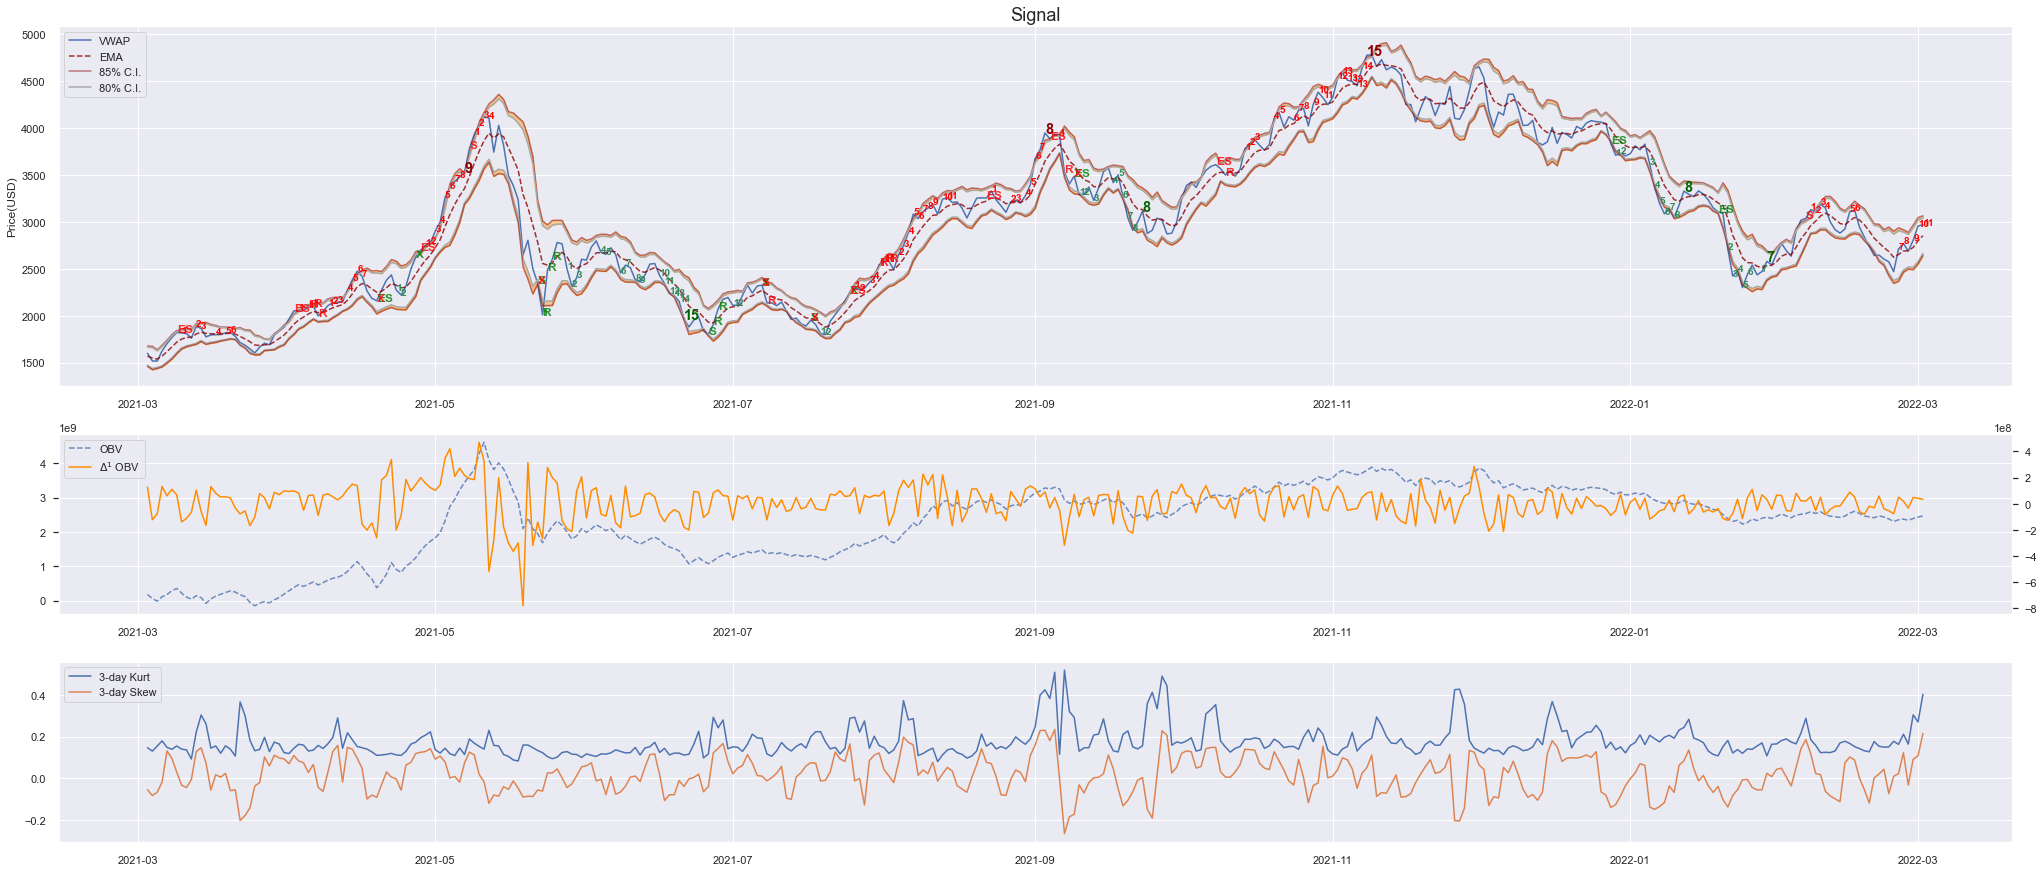

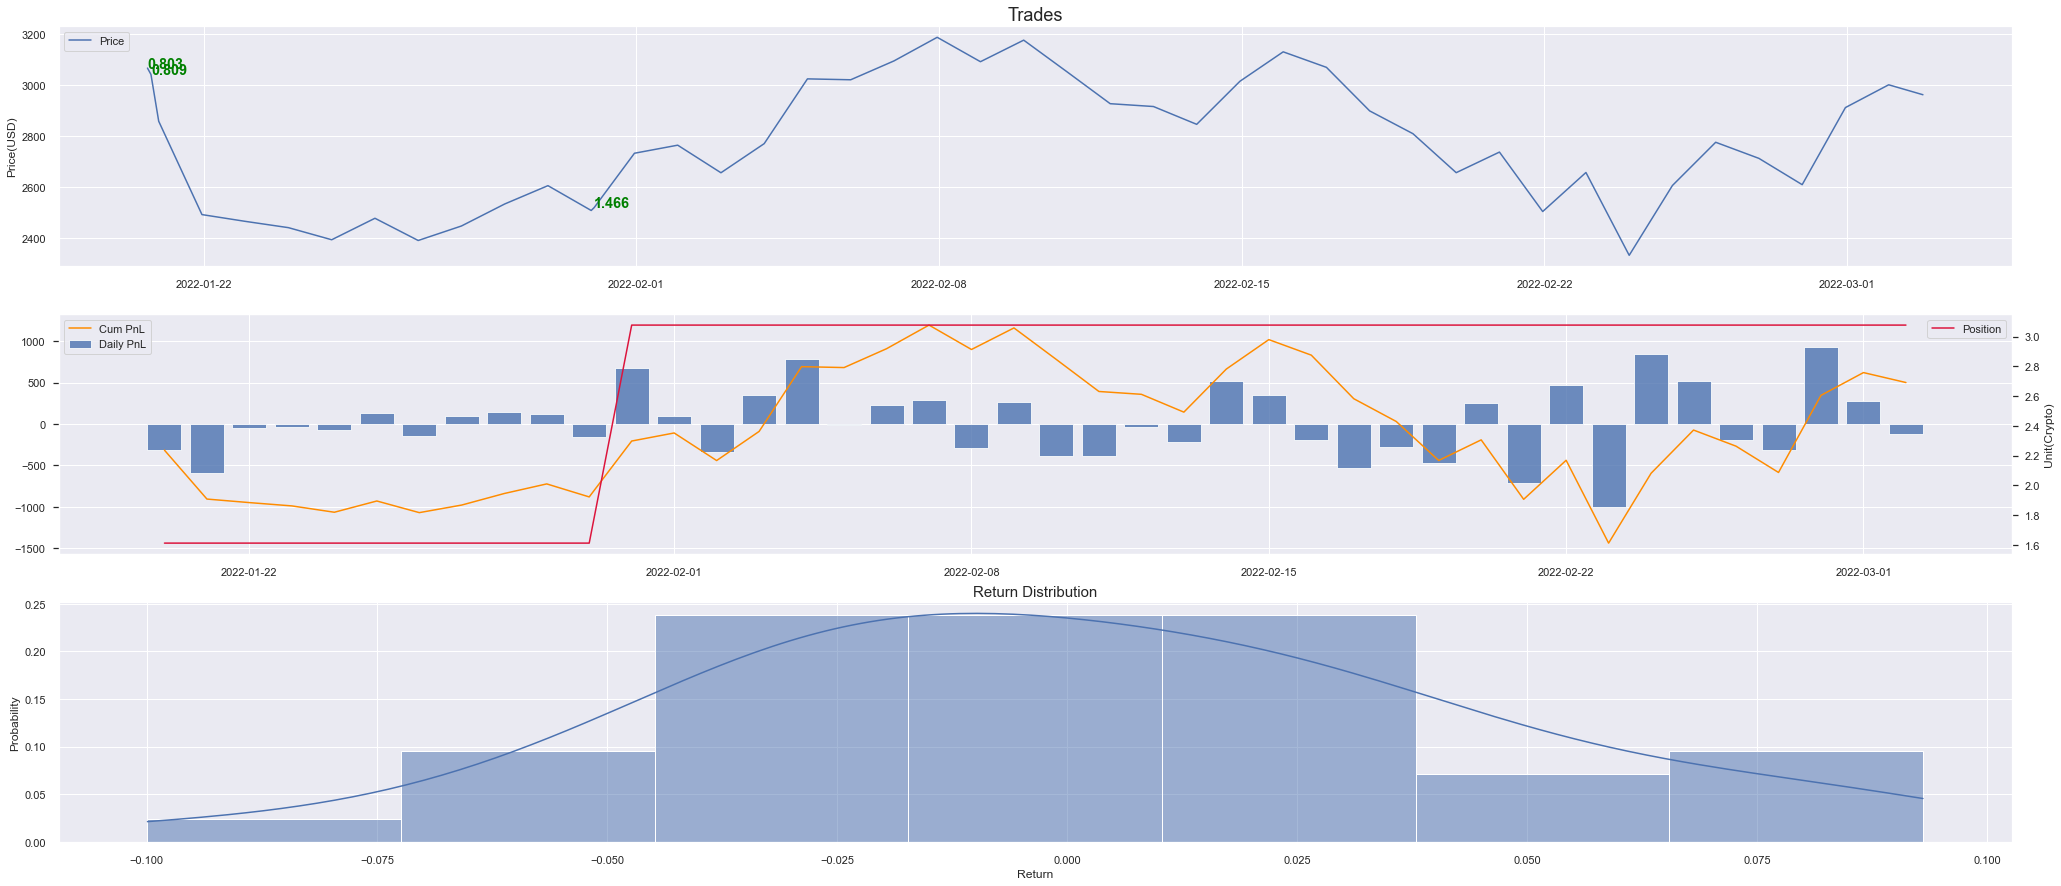

,Max Drawdown($),Downside Beta,Sortino Ratio,Cum PnL,Strategy Return,Return Mean,Return Std,Return Skew,Return Kurtosis
stats,1457.971717,0.189841,0.200433,500.292048,0.058028,0.001191,0.042397,0.128373,-0.030829


In [96]:
trader = Trader(EnhancedDeMark, ticker="eth")
trader.backtest()
trader.plot_signal()
trader.plot_pnl()

Getting Live ETH Data...


Generating Signal: 100%|█████████████████████| 416/416 [00:07<00:00, 57.56it/s]


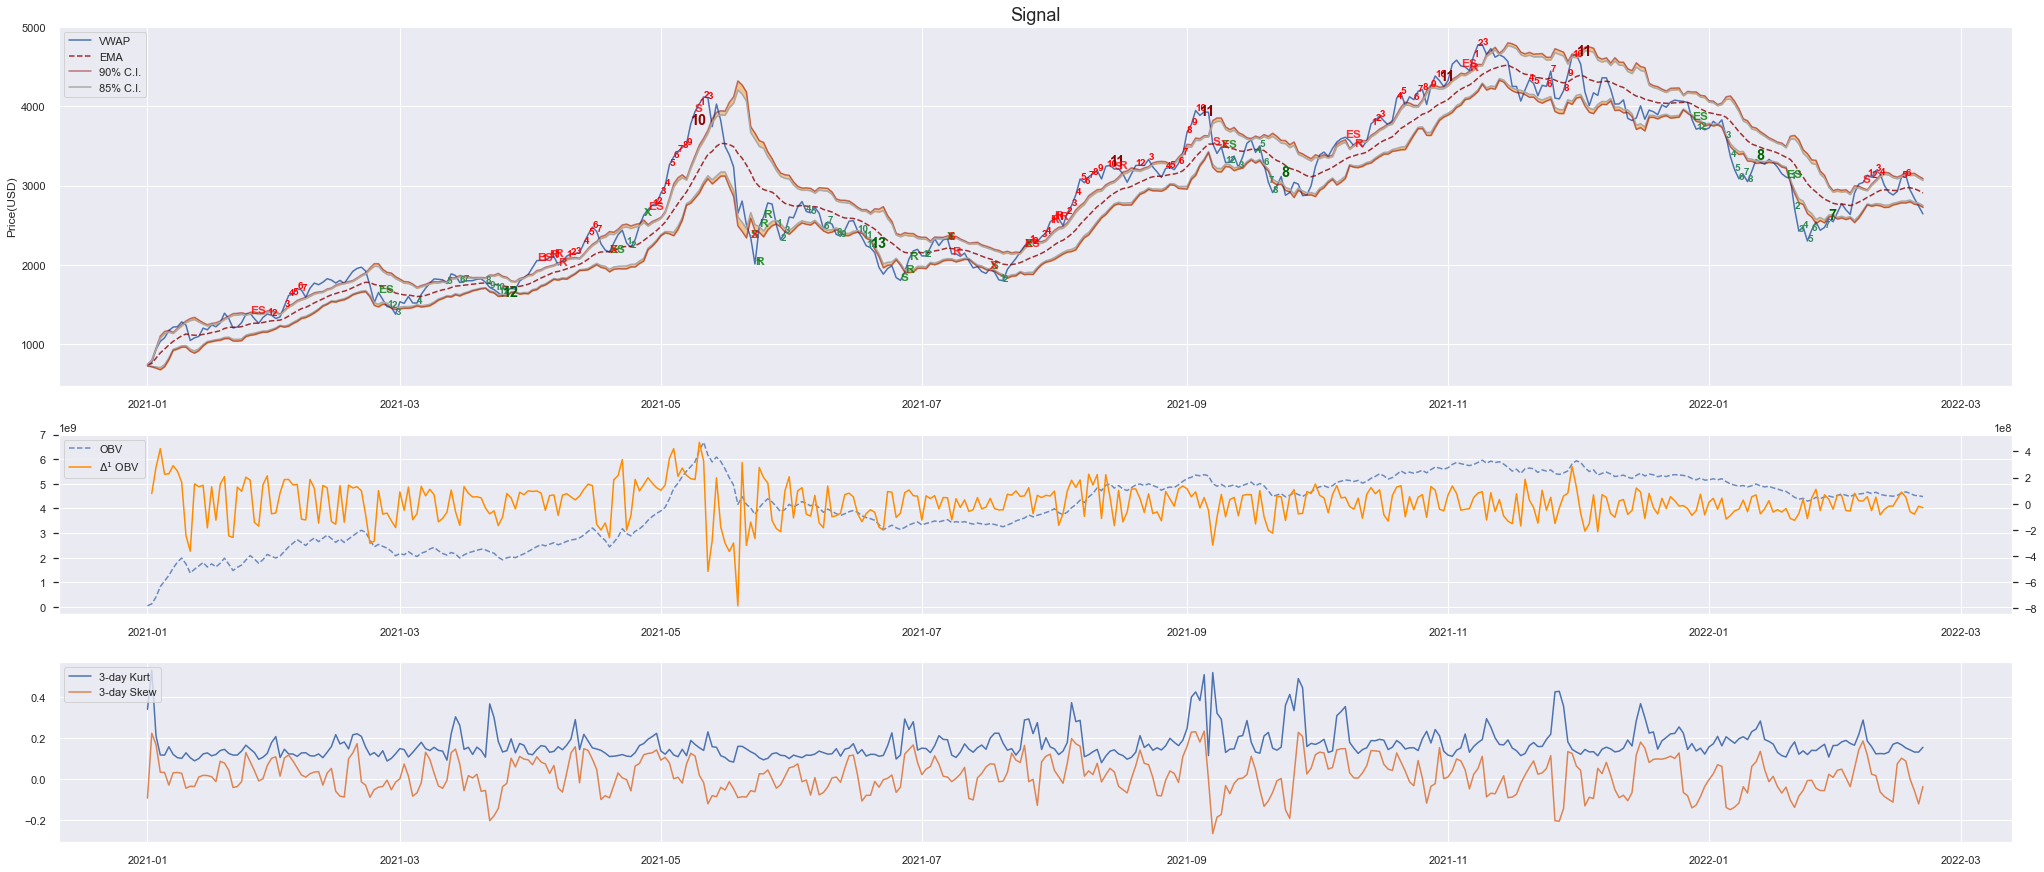

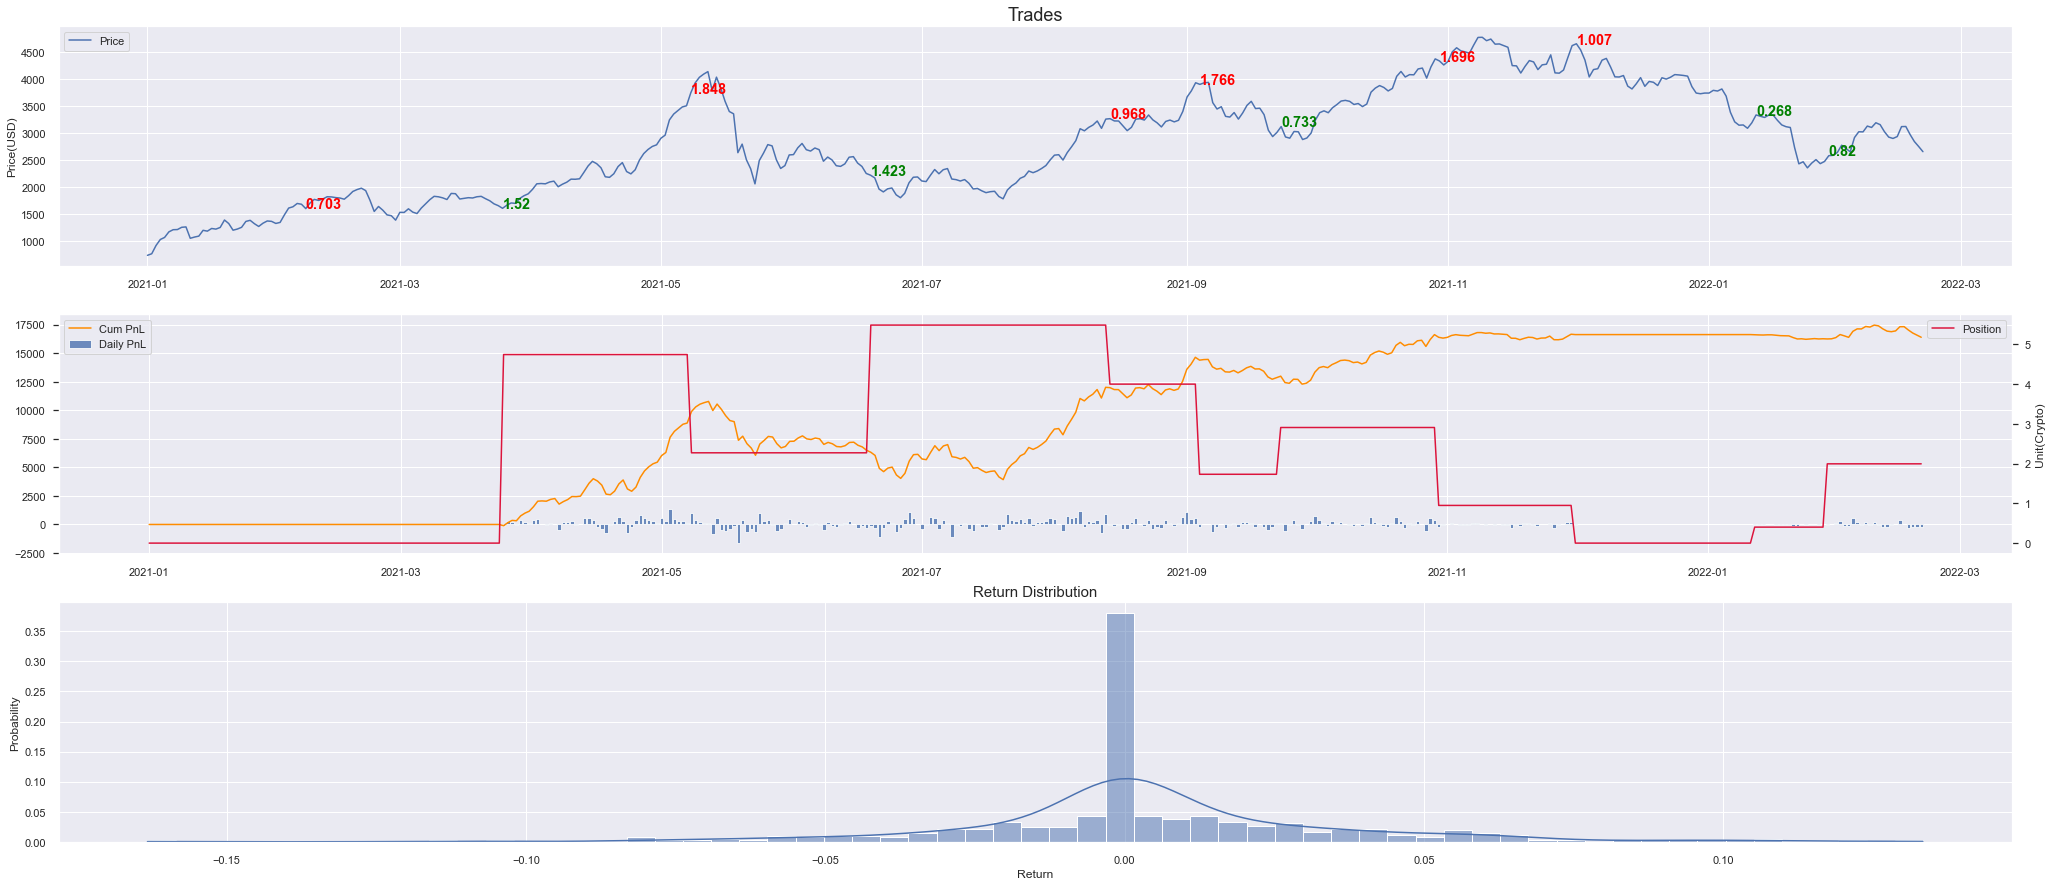

,Max Drawdown($),Downside Beta,Sortino Ratio,Cum PnL,Strategy Return,Return Mean,Return Std,Return Skew,Return Kurtosis
stats,3172.018073,0.329436,0.060358,16390.582571,0.688243,0.00394,0.031528,0.030578,4.129032


In [76]:
backtesterETH = Backtester(EnhancedDeMark, ticker="eth", start="2021")
backtesterETH.base_backtest()
backtesterETH.plot_signal()
backtesterETH.plot_pnl()

In [ ]:
backtesterETH = Backtester(EnhancedDeMark, ticker="eth", start="2018", end="2020")
backtesterETH.plot_signal()
backtesterETH.plot_pnl()

In [ ]:
# backtesterBTC = Backtester(DeMarkBasedTS, ticker="btc", start="2019")
backtesterETH = Backtester(EnhancedDeMark, ticker="eth", start="2021")

In [ ]:
sig = backtesterETH.strategy.signal.loc["2021":]
# index = sig[(sig["buy"]!=0)|(sig["sell"]!=0)].index
index = sig.index
sig.loc[index]

In [ ]:
rolling_skew = mom["skew"].rolling(7).quantile(0.3).loc[index]
rolling_kurt = mom["kurt"].rolling(7).quantile(0.5).loc[index]

In [ ]:
mom = backtesterETH.strategy.bollingbands.signal[["kurt","skew"]].loc["2021":]
# kurt.loc["2020-1":"2021-6"][kurt.loc["2020-1":"2021-6"]<0.1737]
# kurt.loc["2020-1":"2021-6"][kurt.loc["2020-1":"2022-6"] < 0.15]
mom = mom.loc[index]

In [ ]:
mom[(mom["skew"] < rolling_skew) & (mom["kurt"]<rolling_kurt)]

In [ ]:
# start = "2021-1"
# end = "2022-12"
# backtesterETH.plot_signal(start=start, end=end)
# backtesterETH.plot_pnl(start=start, end=end)

In [ ]:
start = "2021"
end = "2022-11"
backtesterETH.plot_signal(start=start, end=end)
backtesterETH.plot_pnl(start=start, end=end)

In [ ]:
backtesterETH = Backtester(DeMarkSequence, ticker="eth", start="2021")
start = "2020"
end = "2022-11"
backtesterETH.plot_signal(start=start, end=end)
backtesterETH.plot_pnl(start=start, end=end)

In [ ]:
backtesterETH.plot_signal(start="2019-11", end="2020-10")
backtesterETH.plot_pnl(start="2019-11", end="2020-10")

In [ ]:
backtesterBTC.plot_signal(days=252)
backtesterBTC.plot_pnl(days=252)

In [ ]:
backtesterBTC.plot_signal(start="2020-2", end="2020-9")
backtesterBTC.plot_pnl(start="2020-2", end="2020-9")

In [ ]:
backtesterBTC.plot_signal(start="2020-2", end="2021-1")
backtesterBTC.plot_pnl(start="2020-2", end="2021-1")

In [ ]:
trades = pd.DataFrame(requests.get('https://api.pro.coinbase.com/products/ETH-USD/trades').json())
trades.head()

In [ ]:
from scipy.integrate import quad

In [ ]:
data = backtesterETH.strategy.hourly_data["close"]

In [ ]:
def realized_kurt(data):
#     data = np.log(data)
    g = lambda x: min(x, 1-x)
    g2 = lambda x: pow(g(x),2)
    g4 = lambda x: pow(g(x),4)
    g2bar = quad(g2,0,1)[0]
    g4bar = quad(g4,0,1)[0]
    k = 3 
    def f(grid):
        res = 0
        ret = grid.diff(1)
        for i in range(1,len(ret)):
            res += g(i/k)*ret[i]
        return res
    def f_bar(grid):
        res = 0
        ret = grid.diff(1)
        for i in range(1,len(ret)):
            res += ((g(i/k)-g((i-1)/k))*ret[i])**2
        return res
    
    deltaY = data.rolling(window=k).apply(f).dropna()
    deltaYBar = data.rolling(window=k).apply(f_bar).dropna()

    realizedKurt = (deltaY**4).sum() / (k*g4bar)
    realizedVar = ((deltaY**2).sum()/k - deltaYBar.sum()/(2*k))/g2bar
    return realizedKurt / (realizedVar**2)

In [ ]:
res = []
for _ in tqdm(range(10)):
    size= 72
    s = pd.Series(data=np.random.normal(2,1.5,size), index=pd.date_range(start="2020-01-01", periods=size))
    res.append(realized_kurt(s))

In [ ]:
np.quantile(res,0.65)

In [ ]:
sub = data.loc["2019-1-1":"2021-11-20"]

In [ ]:
kurt = sub.resample("1d").apply(realized_kurt)

In [ ]:
# kurt = sub.rolling(window=48).apply(realized_kurt)

In [ ]:
with pd.option_context("display.max_rows", 100000):
    print(kurt)

In [ ]:
kurt.plot(figsize=(20,5))

In [ ]:
 def TSRV(data, k, j):
        data = np.log(data)
        n = len(data)
        nbarK, nbarJ = (n-k+1)/k, (n-j+1)/j
        adj = (1-(nbarK/nbarJ))**(-1)
        RV_k = np.square(data - data.shift(k)).sum() / k
        RV_j = np.square(data - data.shift(j)).sum() / j
        RV = adj * (RV_k - (nbarK/nbarJ) * RV_j)
        sqrt = np.sqrt(max(0, RV))
        return sqrt
    
    def realized_moments(data, k):
        data = np.log(data)
        g = lambda x: min(x, 1-x)
        g2 = lambda x: pow(g(x),2)
        g3 = lambda x: pow(g(x),2)
        g4 = lambda x: pow(g(x),4)
        g2bar = quad(g2,0,1)[0]
        g3bar = quad(g3,0,1)[0]
        g4bar = quad(g4,0,1)[0]
        def f(grid):
            res = 0
            ret = grid.diff(1)
            for i in range(1,len(ret)):
                res += g(i/k)*ret[i]
            return res
        def f_bar(grid):
            res = 0
            ret = grid.diff(1)
            for i in range(1,len(ret)):
                res += ((g(i/k)-g((i-1)/k))*ret[i])**2
            return res

In [ ]:
params = {"step":60, "limit":300}
r = requests.get(f"https://www.bitstamp.net/api/v2/ohlc/btcusd/", params=params)
data = json.loads(r.text)
data = pd.DataFrame(data['data']['ohlc'])
data.index = [pd.to_datetime(int(t), unit="s")-timedelta(hours=6) for t in data["timestamp"]]
data = data.drop(columns="timestamp")
for c in data.columns:
    data[c] = pd.to_numeric(data[c])
data["Volume USD"] = data["volume"] * data["close"]
data = data.drop(columns=["volume"])
data = data.sort_index(ascending=True)

In [ ]:
data
